# Environment Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

# Data Preparation

## Paths to ZIP files and extraction

In [ ]:
!unzip -qo "/content/drive/My Drive/Colab Notebooks/Final_Project_data/train_data_unlabeled.zip" -d '/content/train_data'
!unzip -qo "/content/drive/My Drive/Colab Notebooks/Final_Project_data/test_data_unlabeled.zip" -d '/content/test_data'
x_train_extracted_path = "/content/train_data/train_data_unlabeled"
x_test_extracted_path = "/content/test_data/test_data_unlabeled"

## Load and preprocess images

In [ ]:
# Load images

def load_images(folder_path):
    images, valid_image_names = [], []
    for name in sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[1][:-4])):
        if name.startswith("img_") and name.endswith(".png"):
            img = Image.open(os.path.join(folder_path, name))
            img = np.array(img)[:,:,:3]  # Keep only the first 3 channels (RGB)
            images.append(img)
    return np.array(images)

x_train_images = load_images(x_train_extracted_path)
x_test_images = load_images(x_test_extracted_path)
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Final_Project_data/y_train.csv')
y_train_encoded = to_categorical(y_train.target)

# Split into training and validation sets
x_train, x_val, y_train_encoded, y_val_encoded = train_test_split(x_train_images, y_train_encoded, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# Model Building

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training


In [ ]:
history = model.fit(x_train, y_train_encoded, epochs=30, validation_data=(x_val, y_val_encoded))

Epoch 1/30
405/405 [==============================] - 4s 7ms/step - loss: 0.6580 - accuracy: 0.7248 - val_loss: 0.3995 - val_accuracy: 0.8483
Epoch 2/30
405/405 [==============================] - 2s 5ms/step - loss: 0.3491 - accuracy: 0.8673 - val_loss: 0.3014 - val_accuracy: 0.8882
Epoch 3/30
405/405 [==============================] - 2s 5ms/step - loss: 0.2803 - accuracy: 0.8959 - val_loss: 0.2856 - val_accuracy: 0.8872
Epoch 4/30
405/405 [==============================] - 3s 7ms/step - loss: 0.2259 - accuracy: 0.9144 - val_loss: 0.2512 - val_accuracy: 0.9033
Epoch 5/30
405/405 [==============================] - 2s 6ms/step - loss: 0.1917 - accuracy: 0.9292 - val_loss: 0.1655 - val_accuracy: 0.9407
Epoch 6/30
405/405 [==============================] - 2s 5ms/step - loss: 0.1802 - accuracy: 0.9340 - val_loss: 0.1637 - val_accuracy: 0.9422
Epoch 7/30
405/405 [==============================] - 3s 8ms/step - loss: 0.1570 - accuracy: 0.9444 - val_loss: 0.1267 - val_accuracy: 0.9574
Epoch 

# Model Evaluation and Visualization


## Classification Examples




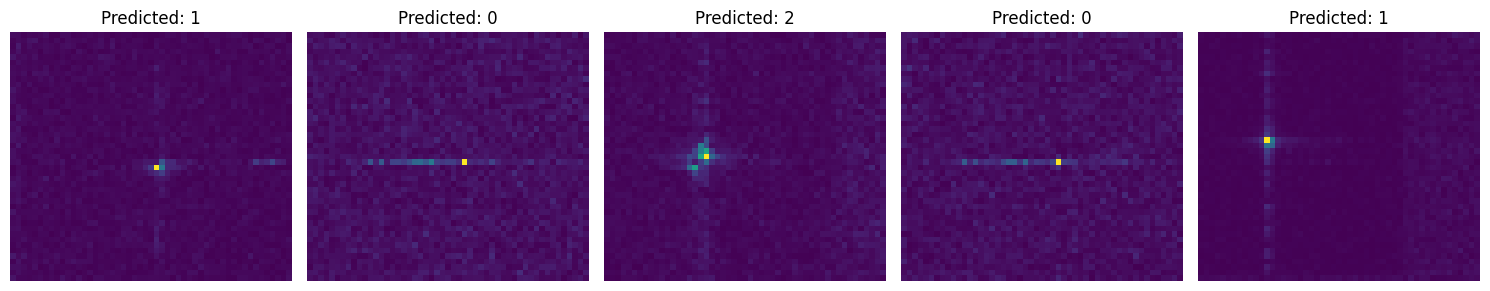

In [ ]:
import random

def visualize_classification_examples(images, predictions, num_examples=5):
    # Generate a list of random indices from the image dataset
    random_indices = random.sample(range(len(images)), num_examples)

    # Set up the matplotlib figure and axes, based on the number of examples
    fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 3, 3))

    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(images.shape[1], images.shape[2], -1))
        ax.set_title(f'Predicted: {predictions[idx]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Now call the function, which should give you different images and predictions each time it's run
visualize_classification_examples(x_test_images, test_pred_classes, num_examples=5)


## Plot training history

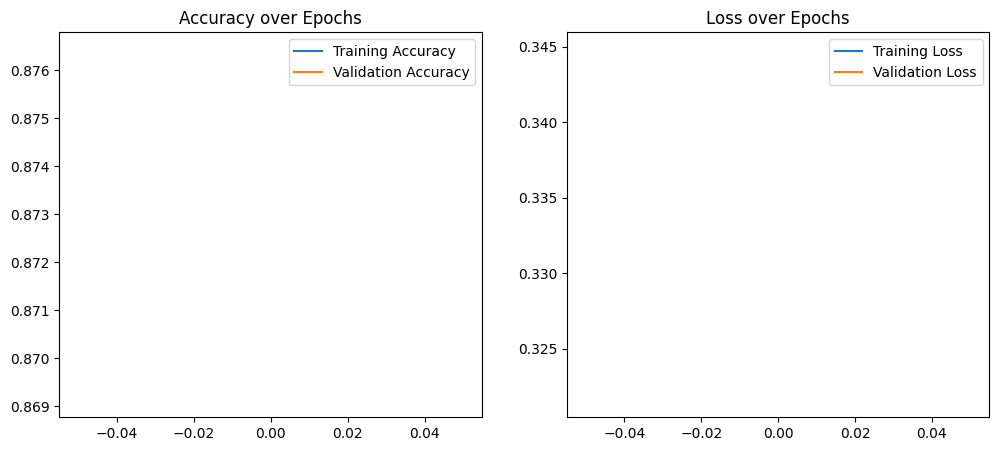

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

## Confusion Matrix Visualization

102/102 [==============================] - 5s 46ms/step


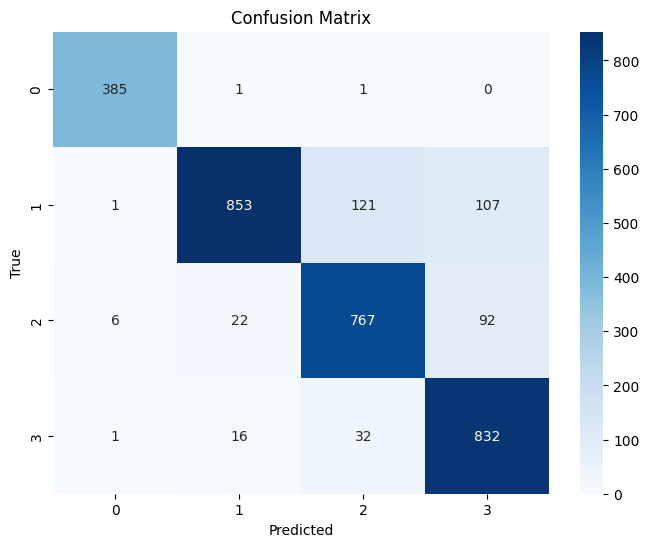

In [ ]:
val_pred_labels = np.argmax(model.predict(x_val), axis=1)
y_true_labels = np.argmax(y_val_encoded, axis=1)

cm = confusion_matrix(y_true_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true_labels, val_pred_labels)
precision = precision_score(y_true_labels, val_pred_labels, average='weighted')
recall = recall_score(y_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, val_pred_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9716
Precision: 0.9718
Recall: 0.9716
F1 Score: 0.9715


# Submission

In [ ]:
# Predict on test data
test_predictions = model.predict(x_test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': np.arange(len(test_pred_classes)),
    'target': test_pred_classes
})

# Define submission file path
submission_file_path = '/content/drive/My Drive/Colab Notebooks/Final_Project_data/submission.csv'
# Save submission file
submission_df.to_csv(submission_file_path, index=False)

# Display first few rows to verify
print(submission_df.head())

# Optional: Visualize some predictions
def visualize_predictions(images, true_labels, pred_labels, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(images.shape[1], images.shape[2], -1))
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

150/150 [==============================] - 1s 7ms/step
   id  target
0   0       1
1   1       3
2   2       3
3   3       1
4   4       3
